# Training EDA : Analyze the frequentation of the SNCF Station during from 2019 and 2025

Guillaume EGU

## Overview 

N/A

## Contents

<ul style ="padding-left: 75px;"> 
    <li>Import Libraries </li>
    <li>Functions </li>
    <li>Data Loading & Overview </li>
    <li>Data Exploration </li>
    <li>Feature Engineering </li>
    <li>Prepare data for modelling</li>
</ul>
</p>

<hr>

### Import Libraries

<hr>

In [104]:
import pandas as pd
import plotly.express as px
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

<hr>

### Functions

<hr>

In [105]:
def rename_col(df: pd.DataFrame):
    df=df.copy()

    df.columns = (
        df.columns
        .str.replace('\ufeff', '', regex=False)  # enlève BOM si présent
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
    )
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df

def parse_tranche_horaire_to_hours(s: str):
    """
    Transforme une tranche horaire textuelle en (start_hour, end_hour) approximatives.
    Exemples attendus dans les données:
      - 'Avant 6h' -> (0, 6)
      - 'De 6h à 10h' -> (6, 10)
      - 'De 10h à 16h' -> (10, 16)
      - 'De 16h à 20h' -> (16, 20)
      - 'Après 20h' -> (20, 24)
    """
    if not isinstance(s, str) or not s:
        return (np.nan, np.nan)
    s = s.lower().strip()
    if 'avant' in s and '6' in s:
        return (0, 6)
    if 'après' in s or 'apres' in s:
        num = ''.join(ch for ch in s if ch.isdigit())
        h = int(num) if num else 20
        return (h, 24)
    if 'de' in s and 'à' in s:
        parts = s.replace('à', 'a').split()
        nums = [int(''.join(ch for ch in p if ch.isdigit())) for p in parts if any(ch.isdigit() for ch in p)]
        if len(nums) == 2:
            return (nums[0], nums[1])
    return (np.nan, np.nan)

<hr>

### Data loading & Overview

<hr>

In [123]:
# Reading the data & take a look on the first rows
df = pd.read_csv("comptage-voyageurs-trains-transilien.csv", sep=';')
df = rename_col(df)
df.head()


,nom_gare,code_gare,type_jour,date,annee,ligne,axe,tranche_horaire,somme_de_montants
0,ACHERES-VILLE,87381657,DIM,2022-11-20,2022,A,A,Avant 6h,39
1,BEYNES,87393363,SAM,2024-01-20,2024,N,N,De 10h à 16h,94
2,CHAMP-DE-COURSES-D'ENGHIEN,87276030,DIM,2024-01-21,2024,H,H,De 10h à 16h,727
3,CHAMP-DE-COURSES-D'ENGHIEN,87276030,SAM,2024-01-20,2024,H,H,Avant 6h,47
4,CHAMP-DE-MARS-TOUR-EIFFEL,87393058,DIM,2025-09-02,2025,C,C,Avant 6h,8


In [124]:
# Getting columns and types to see what pre-processing things I have to do
print("Dimensions :", df.shape)
print(df.info())

Dimensions : (7328, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7328 entries, 0 to 7327
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   nom_gare           7328 non-null   object        
 1   code_gare          7328 non-null   int64         
 2   type_jour          7328 non-null   object        
 3   date               7328 non-null   datetime64[ns]
 4   annee              7328 non-null   int64         
 5   ligne              7328 non-null   object        
 6   axe                7328 non-null   object        
 7   tranche_horaire    7328 non-null   object        
 8   somme_de_montants  7328 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 515.4+ KB
None


In [125]:
#Let's analyse the object columns 
df_objects_columns = df.select_dtypes(include=['object'])
print(df_objects_columns.dtypes)

print(df_objects_columns['nom_gare'].apply(type).unique())
print(df_objects_columns['type_jour'].apply(type).unique())
print(df_objects_columns['ligne'].apply(type).unique())
print(df_objects_columns['axe'].apply(type).unique())
print(df_objects_columns['tranche_horaire'].apply(type).unique())

nom_gare           object
type_jour          object
ligne              object
axe                object
tranche_horaire    object
dtype: object
[<class 'str'>]
[<class 'str'>]
[<class 'str'>]
[<class 'str'>]
[<class 'str'>]


In [129]:
#Let's check unique value to detect any error in the dataset
#Class, Number = np.unique(df['nom_gare'], return_counts=True)
Class, Number = np.unique(df['type_jour'], return_counts=True)
#Class, Number = np.unique(df['ligne'], return_counts=True)
#Class, Number = np.unique(df['axe'], return_counts=True)
#Class, Number = np.unique(df['tranche_horaire'], return_counts=True)
print(Class, Number)

['DIM' 'JOB' 'SAM'] [2393 2502 2433]


In [130]:
#It's seems there is no errors in the datasets
#Let's now check the description
df.describe(include="all")

,nom_gare,code_gare,type_jour,date,annee,ligne,axe,tranche_horaire,somme_de_montants
count,7328,7.328000e+03,7328,7328,7328.000000,7328,7328,7328,7328.000000
unique,434,NaN,3,NaN,NaN,17,21,5,NaN
top,PARIS-SAINT-LAZARE,NaN,JOB,NaN,NaN,C,C,Après 20h,NaN
freq,74,NaN,2502,NaN,NaN,1223,1118,1524,NaN
mean,NaN,8.740263e+07,NaN,2023-12-16 20:05:34.061135360,2023.620087,NaN,NaN,NaN,893.398062
min,NaN,8.700148e+07,NaN,2019-03-16 00:00:00,2019.000000,NaN,NaN,NaN,0.000000
25%,NaN,8.727611e+07,NaN,2023-11-19 00:00:00,2023.000000,NaN,NaN,NaN,40.000000
50%,NaN,8.738237e+07,NaN,2024-01-20 00:00:00,2024.000000,NaN,NaN,NaN,181.000000
75%,NaN,8.754524e+07,NaN,2024-04-23 00:00:00,2024.000000,NaN,NaN,NaN,702.000000
max,NaN,8.798872e+07,NaN,2025-11-02 00:00:00,2025.000000,NaN,NaN,NaN,47213.000000


In [131]:
#Let's check missing values
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_ratio").head(20))

,missing_ratio
nom_gare,0.0
code_gare,0.0
type_jour,0.0
date,0.0
annee,0.0
ligne,0.0
axe,0.0
tranche_horaire,0.0
somme_de_montants,0.0


In [ ]:
#No Missing Values

<hr>

### Data Exploration

<hr>

In [132]:
"""
    Ajoute des features temporelles dérivées de la date et tranche horaire.
"""
df = df.copy()
if 'date' in df.columns:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday  # 0=lundi
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

if 'tranche_horaire' in df.columns:
    hours = df['tranche_horaire'].apply(parse_tranche_horaire_to_hours)
    df['start_hour'] = hours.apply(lambda x: x[0])
    df['end_hour'] = hours.apply(lambda x: x[1])
    df['hour_bucket'] = (df['start_hour'] + df['end_hour']) / 2.0
print(df.head())

                     nom_gare  code_gare type_jour       date  annee ligne  \
0               ACHERES-VILLE   87381657       DIM 2022-11-20   2022     A   
1                      BEYNES   87393363       SAM 2024-01-20   2024     N   
2  CHAMP-DE-COURSES-D'ENGHIEN   87276030       DIM 2024-01-21   2024     H   
3  CHAMP-DE-COURSES-D'ENGHIEN   87276030       SAM 2024-01-20   2024     H   
4   CHAMP-DE-MARS-TOUR-EIFFEL   87393058       DIM 2025-09-02   2025     C   

  axe tranche_horaire  somme_de_montants  year  month  day  weekday  \
0   A        Avant 6h                 39  2022     11   20        6   
1   N    De 10h à 16h                 94  2024      1   20        5   
2   H    De 10h à 16h                727  2024      1   21        6   
3   H        Avant 6h                 47  2024      1   20        5   
4   C        Avant 6h                  8  2025      9    2        1   

   is_weekend  start_hour  end_hour  hour_bucket  
0           1           0         6          3.0  
1 

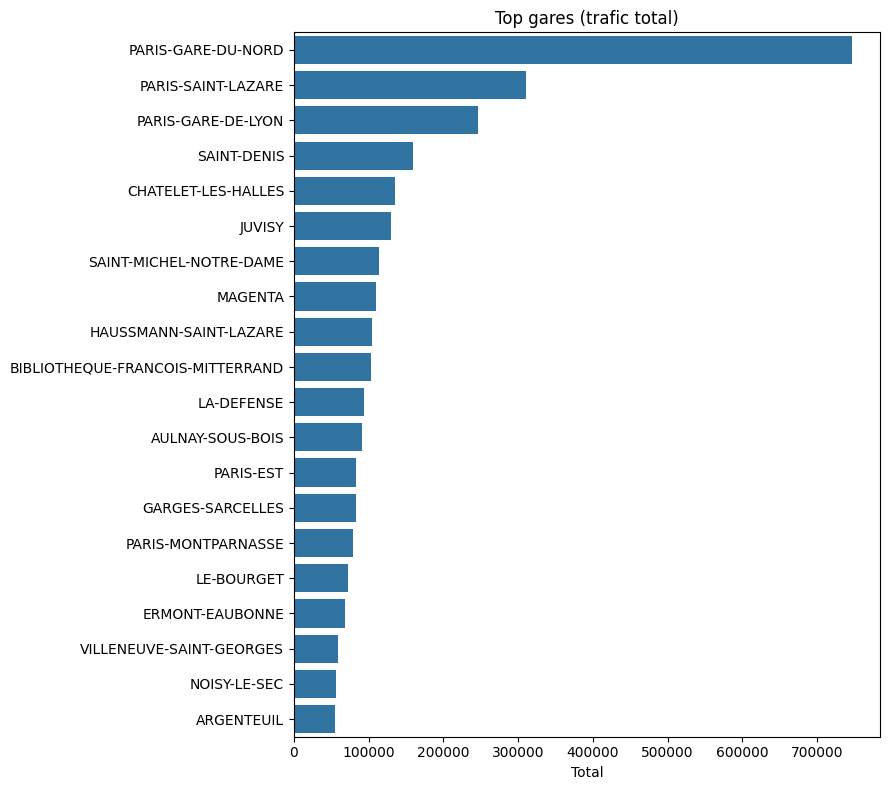

In [133]:
# Top gares (total)
if 'nom_gare' in df.columns:
    top_gares = df.groupby('nom_gare')['somme_de_montants'].sum()
    s = top_gares.sort_values(ascending=False).head(20)
    plt.figure(figsize=(9, min(0.4*len(s), 10)))
    sns.barplot(x=s.values, y=s.index)
    plt.title("Top gares (trafic total)")
    plt.xlabel('Total')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [134]:
# Trafic par ligne
if 'ligne' in df.columns:
    trafic_lignes = df.groupby('ligne')['somme_de_montants'].sum().sort_values(ascending=False)
    fig = px.bar(trafic_lignes, title="Trafic total par ligne")
    fig.update_layout(xaxis_title='Ligne', yaxis_title='Trafic total')
    fig.show()

In [135]:
# Répartition par tranche horaire (ordre approximatif par centre de tranche)
if 'tranche_horaire' in df.columns:
    ordre = (df[['tranche_horaire','hour_bucket']]
             .drop_duplicates()
             .sort_values('hour_bucket'))['tranche_horaire'].tolist()
    trafic_tranches = (df
        .groupby('tranche_horaire')['somme_de_montants']
        .sum()
        .reindex(ordre))
    fig = px.bar(trafic_tranches, title="Trafic total par tranche horaire")
    fig.update_layout(xaxis_title='Tranche horaire', yaxis_title='Trafic total')
    fig.show()

In [136]:
# Semaine vs week-end
if 'is_weekend' in df.columns:
    agg = df.groupby('is_weekend')['somme_de_montants'].sum()
    labels = ['Semaine (0)', 'Weekend (1)']
    fig = px.pie(values=agg.values, names=[labels[i] for i in agg.index], title="Part du trafic : Semaine vs Weekend")
    fig.show()

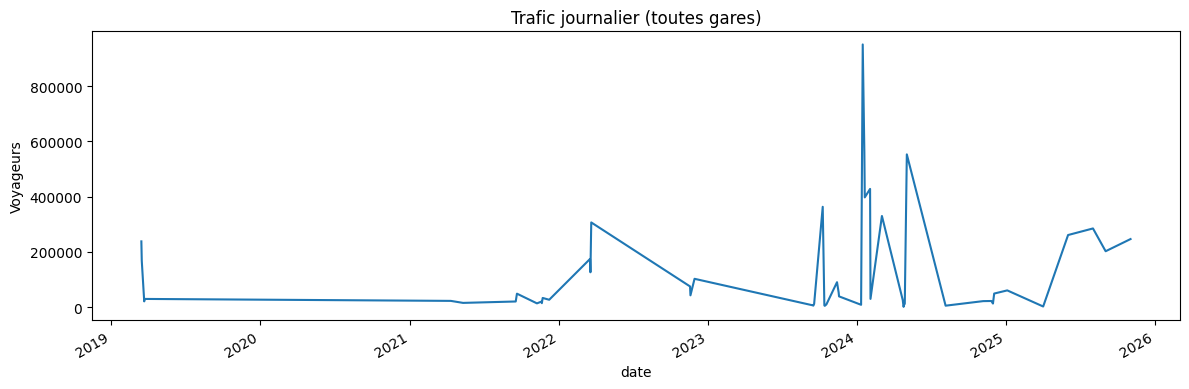

In [137]:
# Evolution temporelle (journalier global)
daily = df.groupby('date')['somme_de_montants'].sum().sort_index()
plt.figure(figsize=(12,4))
daily.plot()
plt.title("Trafic journalier (toutes gares)")
plt.ylabel("Voyageurs")
plt.tight_layout()
plt.show()

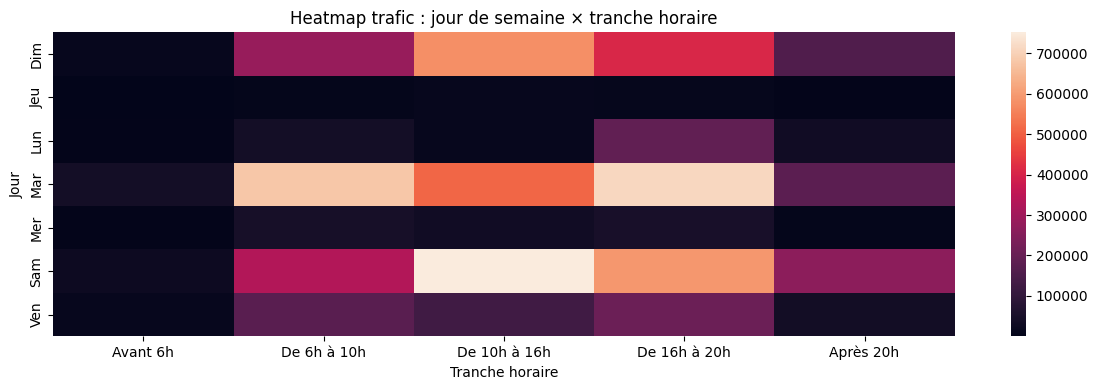

In [140]:
# Heatmap jour_de_semaine x tranche horaire (somme)
if {'weekday','tranche_horaire','somme_de_montants'}.issubset(df.columns):
    pivot = (df
             .groupby(['weekday','tranche_horaire'])['somme_de_montants']
             .sum()
             .reset_index())
    # ordonner colonnes
    pivot['weekday_name'] = pivot['weekday'].map({0:'Lun',1:'Mar',2:'Mer',3:'Jeu',4:'Ven',5:'Sam',6:'Dim'})
    pivot = pivot.merge(
        df[['tranche_horaire','hour_bucket']].drop_duplicates(),
        on='tranche_horaire', how='left'
    )
    heat = pivot.pivot_table(index='weekday_name', columns='tranche_horaire', values='somme_de_montants', aggfunc='sum')
    # réordonner colonnes par hour_bucket
    ordre_tranches = (
        df[['tranche_horaire','hour_bucket']]
        .drop_duplicates()
        .sort_values('hour_bucket')['tranche_horaire']
        .tolist()
    )
    heat = heat[ordre_tranches]
    plt.figure(figsize=(12,4))
    sns.heatmap(heat, annot=False)
    plt.title("Heatmap trafic : jour de semaine × tranche horaire")
    plt.xlabel("Tranche horaire")
    plt.ylabel("Jour")
    plt.tight_layout()
    plt.show()